# How to use cross-correlation to find shifts between two images

Cross correlation of two images is a powerful tool to find a shift between them. 
Unfortunately, the result can be unstable and dependable of noise. Here I will show how to do things properly.

### Import data

In [1]:
import numpy as np
import tifffile
from maximus48 import var
from maximus48.tomo_proc3 import Processor, F

   
N_steps = 10                                                                   # Number of projections per degree
N_start = 1                                                                    # index of the first file
N_finish = 3600                                                                # index of the last file

data_name = 'Platy-Platy_10808'
folder = '/Users/mpolikarpov/data_server/raw_data/10808_full/'

distances =  (1,2)
ROI = (0,20,2048,2048)


# some parameters
N_distances  = 2

# create a class to store all necessary parameters 
Pro = Processor(ROI, folder, N_start, N_finish, compNpad = 8)                 

# set proper paths
Pro.init_paths(data_name, folder, distances) 

# read images
proj = np.zeros(N_distances, dtype = 'object')
for i in range(N_distances):
    proj[i] = tifffile.imread(Pro.images[i][2500:3000])[:,ROI[1]:ROI[3], ROI[0]:ROI[2]]

This dataset of 500 x2 images is a part of a raw X-ray imaging data with 0.1deg step of sample rotation.
It was acquired at two different distances (camera moved along the beam) with 500 images at each distance. 
Camera movement means, that images (i.e. proj[0][i] and proj[1][i]) are shifted between each other. You may want to correct for this shift if you will use further filtering (like multi-distance phase-retrieval or so).

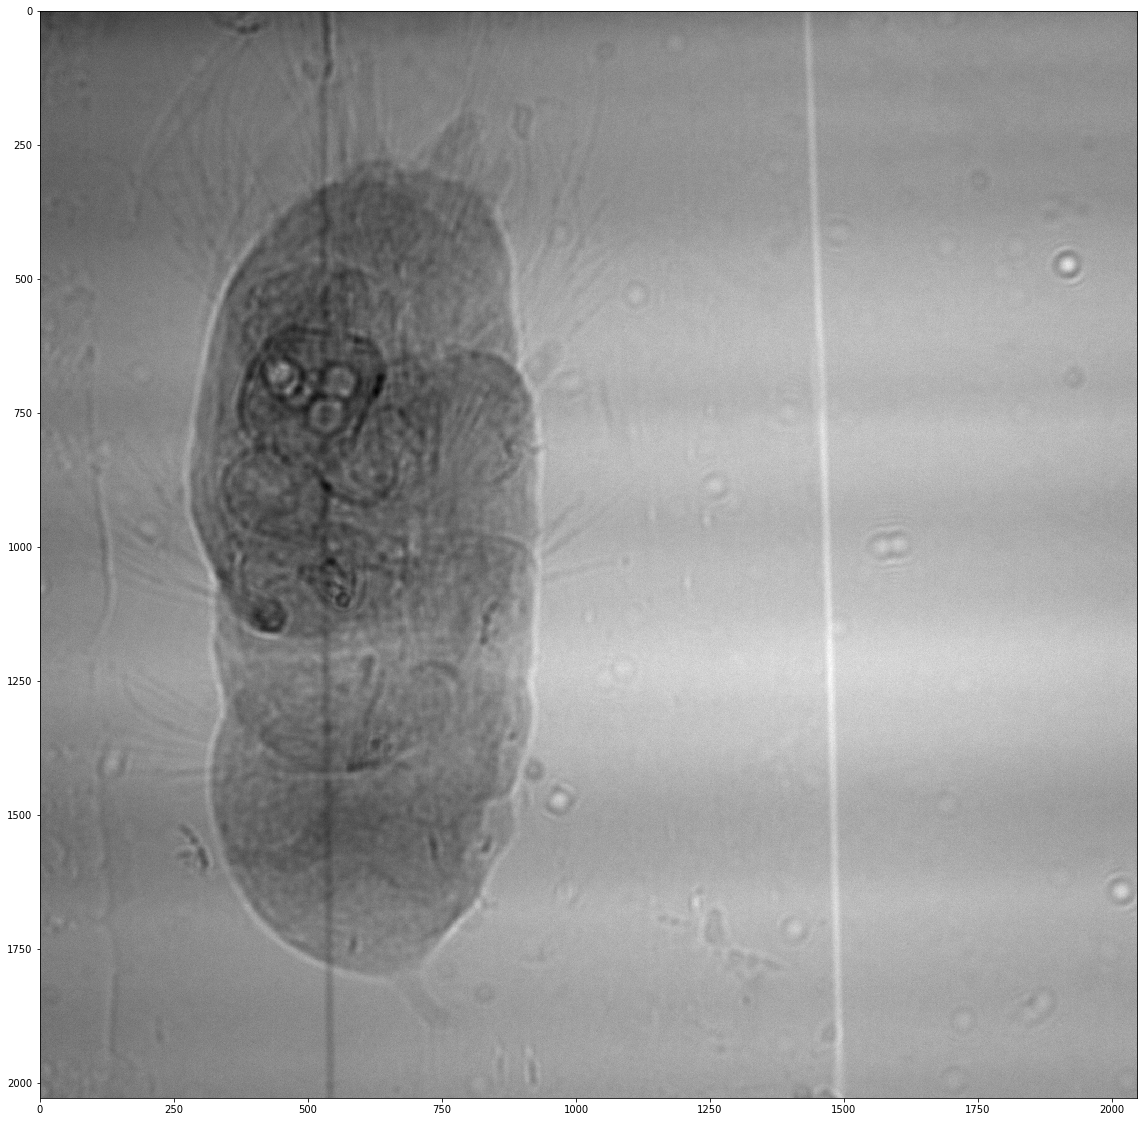

In [4]:
# so the raw data looks like this 
var.show(proj[0][100])

### Cross-correlation at raw images

In [15]:
from skimage.feature import register_translation
import matplotlib.pyplot as plt

def shift_distance(image1, image2, accuracy = 100):
    """
    Finds lateral shift between two images 
    
    Parameters
    __________
    image1 : 2D array

    image2 : 2D array
        y axis
    accuracy: int
        Upsampling factor. Images will be registered within 1 / upsample_factor of a pixel. For example upsample_factor == 20 means the images will be registered within 1/20th of a pixel.    
    """
    shift, error, diffphase = register_translation(image1, image2, accuracy)
    return shift


def calc_shift(proj, accuracy):
    shift = []
    for i in range(len(proj[0])):
        shift.append(shift_distance(proj[0][i], 
                                    proj[1][i], accuracy))
    return shift



First, let's calculate the shift with full images (not cropped):

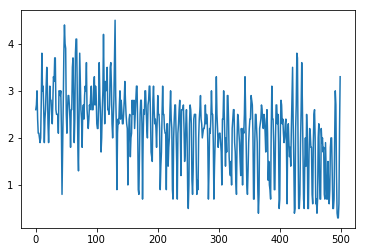

In [9]:
shift = calc_shift(proj, accuracy = 10)
shift = np.array(shift) 
plt.plot(shift[:,0])

Looks reasonable. High-frequency came from the vibration of the X-ray measurement system.

Let's try to reduce the ROI

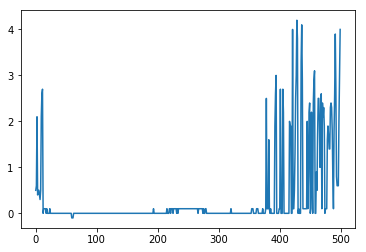

In [38]:
def calc_shift(proj, accuracy = 10):
    shift = []
    for i in range(len(proj[0])):
        shift.append(shift_distance(proj[0][i][750:1250,750:1250], 
                                             proj[1][i][750:1250,750:1250]
                                             , accuracy))
        #print('calculated for ', i)
    return shift


shift = calc_shift(proj, accuracy = 10)
shift = np.array(shift) 
plt.plot(shift[:,0])

###### Here are where errors start. Reducing ROI at raw images makes cross-correlation more sensitive to noise.


### Cross-correlation with filtered images

At this example, there is no need to process all 500 images. Two will be enough for the first demonstration

In [16]:
import scipy
import skimage

def filt_gauss_laplace(image, sigma = 3):
    """
    Consistently applies Gaussian + Laplace (edge) filters to the image
    You need to specify the kernel of the Gaussian filter (sigma)
    Normally, sigma = 3 is good enough to remove white noise.
    """
    image =  skimage.filters.gaussian(image, sigma)
    return scipy.ndimage.laplace(image)

def shift_distance(image1, image2, accuracy = 100):
    """
    Finds lateral shift between two images 
    
    Parameters
    __________
    image1 : 2D array

    image2 : 2D array
        y axis
    accuracy: int
        Upsampling factor. Images will be registered within 1 / upsample_factor of a pixel. For example upsample_factor == 20 means the images will be registered within 1/20th of a pixel.    
    """
    shift, error, diffphase = register_translation(image1, image2, accuracy)
    return shift

def process(image1, image2, sigma = 3, accuracy = 10):
    """
    This function will help to show the difference 
    between cross-correlations of raw and filtered cases
    """
    
    shift1 = shift_distance(image1, image2, accuracy)
    shift2 = shift_distance(filt_gauss_laplace(image1, sigma),
                            filt_gauss_laplace(image2, sigma), accuracy)
    print('shift no filter = ', shift1, 
          '\nshift filter = ', shift2)

#### Filtered case 1: Full images

In [15]:
image1 = proj[0][100]
image2 = proj[1][100]
process(image1, image2)

shift no filter =  [ 2.3 18.4] 
shift filter =  [ 2.8 19.1]


As you see, the results are relatively close (within 0.5 pixel error)

#### Filtered case 2: 3/4 of ROI

In [16]:
image1 = proj[0][100][250:1750,250:1750]
image2 = proj[1][100][250:1750,250:1750]
process(image1, image2)

shift no filter =  [ 2.5 18.6] 
shift filter =  [ 2.7 19.1]


Still fine

#### Filtered case 3: 1/2 of ROI

In [17]:
image1 = proj[0][100][500:1500,500:1500]
image2 = proj[1][100][500:1500,500:1500]
process(image1, image2)

shift no filter =  [0.  0.1] 
shift filter =  [ 2.7 19.1]


Here is where fun starts. Cross-correlation failed at RAW images, while being ok with filtered images.

#### Filtered case 4: 1/4 of ROI

In [20]:
image1 = proj[0][100][800:1200,800:1200]
image2 = proj[1][100][800:1200,800:1200]
process(image1, image2)

shift no filter =  [0.  0.1] 
shift filter =  [ 2.6 19. ]


The same thing.

#### Influence of sigma in the Gaussian filter

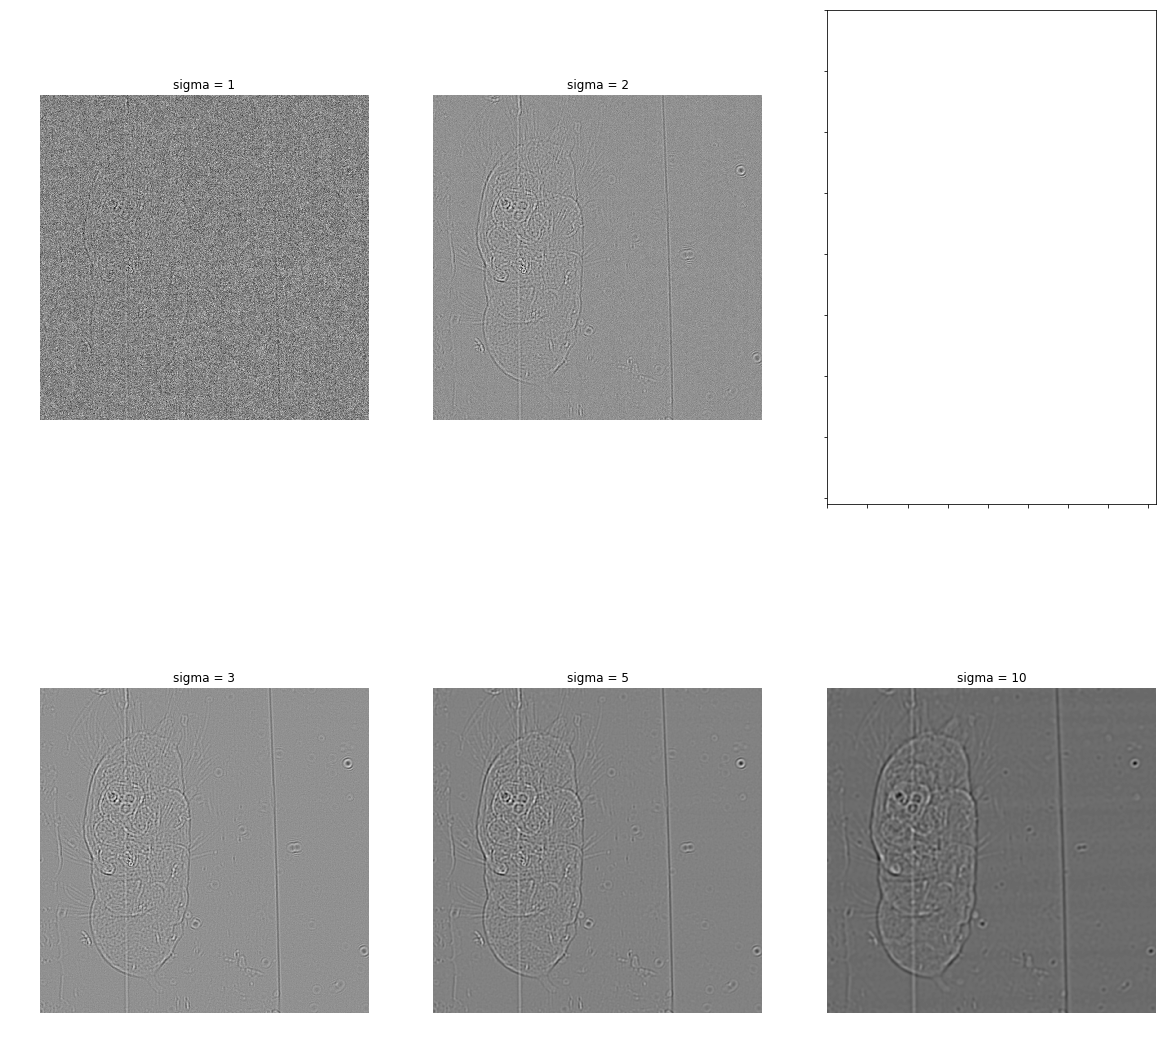

In [11]:
image1 = proj[0][100]

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 20),
                       sharex=True, sharey=True)

ax[0,0].imshow(filt_gauss_laplace(image1,sigma = 1), cmap='gray')
ax[0,0].axis('off')
ax[0,0].set_title('sigma = 1')

ax[0,1].imshow(filt_gauss_laplace(image1,sigma = 2), cmap='gray')
ax[0,1].axis('off')
ax[0,1].set_title('sigma = 2')

ax[1,0].imshow(filt_gauss_laplace(image1,sigma = 3), cmap='gray')
ax[1,0].axis('off')
ax[1,0].set_title('sigma = 3')

ax[1,1].imshow(filt_gauss_laplace(image1,sigma = 5), cmap='gray')
ax[1,1].axis('off')
ax[1,1].set_title('sigma = 5')

ax[1,2].imshow(filt_gauss_laplace(image1,sigma = 10), cmap='gray')
ax[1,2].axis('off')
ax[1,2].set_title('sigma = 10')

plt.show()

###### As you see, sigma = 3-5 is a good balance between the image of having no noise but being still sharp

Now, let's calculate shifts with different sigma. We will still compare it with the case of RAW images. 

In [17]:
# sigma = 3, full ROI
image1 = proj[0][200]
image2 = proj[1][200]
process(image1, image2, sigma = 3, accuracy = 10)

shift no filter =  [ 2.9 17.4] 
shift filter =  [ 3.8 18.3]


In [19]:
# sigma = 5, full ROI
image1 = proj[0][200]
image2 = proj[1][200]
process(image1, image2, sigma = 5, accuracy = 10)

shift no filter =  [ 2.9 17.4] 
shift filter =  [ 3.8 18.3]


In [18]:
# sigma = 10, full ROI
image1 = proj[0][200]
image2 = proj[1][200]
process(image1, image2, sigma = 10, accuracy = 10)

shift no filter =  [ 2.9 17.4] 
shift filter =  [ 4.1 18.2]


So sigma = 3-5 gives same results, while at 10 cross-correlation starts to deviate

In [20]:
# sigma = 3, 1/2 ROI
image1 = proj[0][200][500:1500,500:1500]
image2 = proj[1][200][500:1500,500:1500]
process(image1, image2, sigma = 3, accuracy = 10)

shift no filter =  [0. 0.] 
shift filter =  [ 3.8 18. ]


In [22]:
# sigma = 5, 1/2 ROI
image1 = proj[0][200][500:1500,500:1500]
image2 = proj[1][200][500:1500,500:1500]
process(image1, image2, sigma = 5, accuracy = 10)

shift no filter =  [0. 0.] 
shift filter =  [ 3.8 18. ]


In [23]:
# sigma = 10, 1/2 ROI
image1 = proj[0][200][500:1500,500:1500]
image2 = proj[1][200][500:1500,500:1500]
process(image1, image2, sigma = 5, accuracy = 10)

shift no filter =  [0. 0.] 
shift filter =  [ 3.8 18. ]


### Influence of flatfield-correction

Text(0.5,1,'ff-corrected image2')

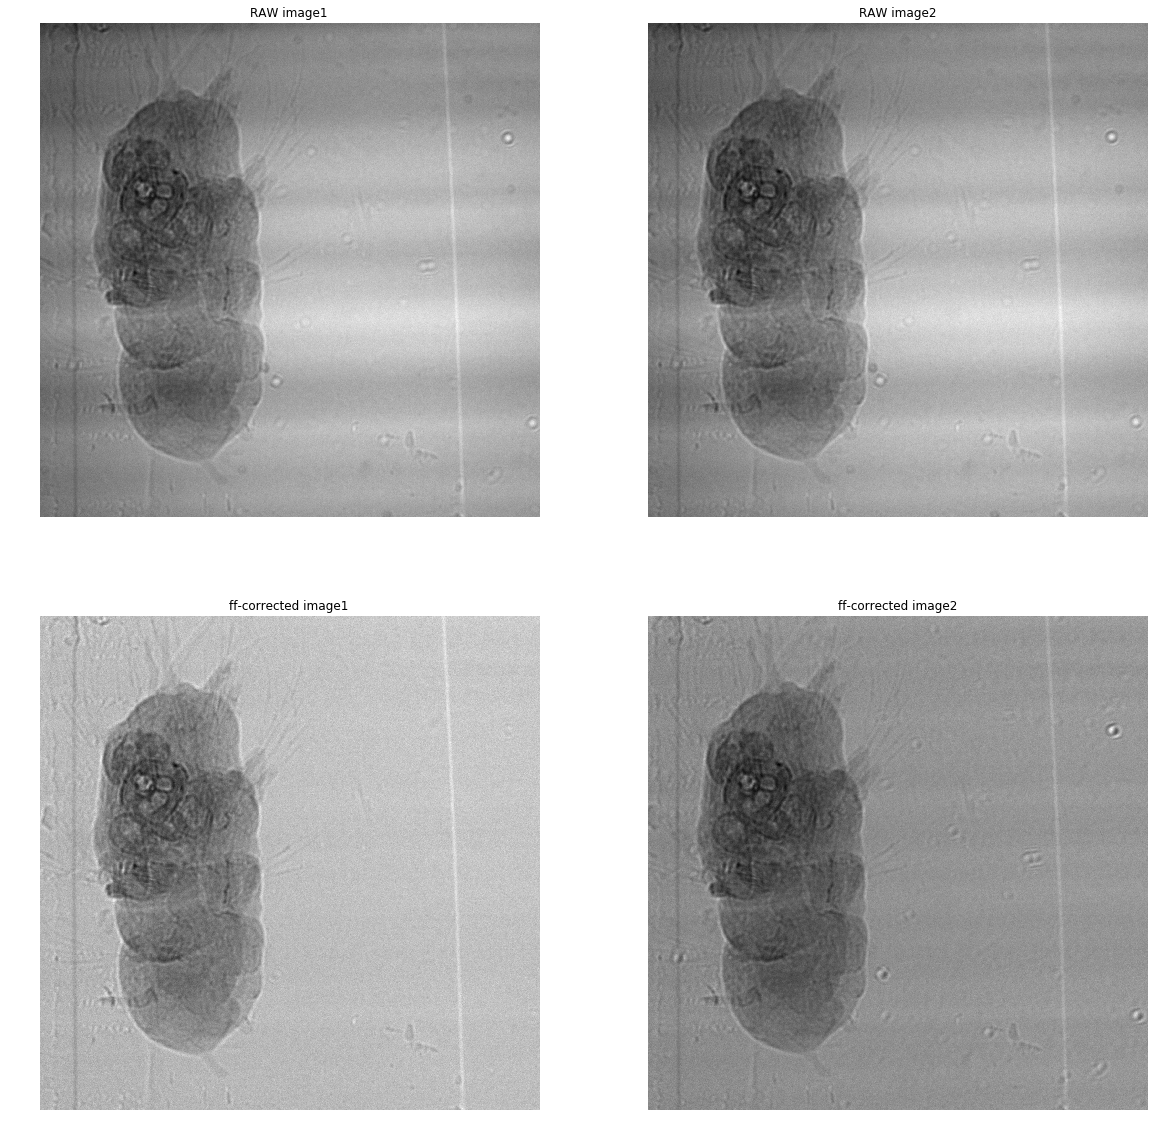

In [29]:
# check another example to understand how ff-correction works
from maximus48 import SSIM_131119 as SSIM

# raw images
image1 = proj[0][200]
image2 = proj[1][200]

#create the list all images in the folder
imlist = var.im_folder(folder)

#read ff-files
flatfield = np.asarray([tifffile.imread(folder+im) for im in imlist if im.startswith('ff')])
flatfield = flatfield[:,ROI[1]:ROI[3], ROI[0]:ROI[2]]

# please transpose the ff-array for the further ff-correction
flatfield = np.transpose(flatfield, (1,2,0))

# images should be set as special classes:
image1_class = SSIM.SSIM_const(image1)
image2_class = SSIM.SSIM_const(image2)
ff_class = SSIM.SSIM_const(flatfield)

# then, you can calculate SSIM metrics for each pair (data-image) - (ff-image)
index1 = SSIM.SSIM(image1_class, ff_class).ssim()
index2 = SSIM.SSIM(image2_class, ff_class).ssim()

# now, simply divide your image by flatfield-image with highest SSIM-index and get a corrected image:
result1 = image1/flatfield[:,:,np.argmax(index1)]
result2 = image2/flatfield[:,:,np.argmax(index2)]


# show both along with RAW images
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 20), sharex=True, sharey=True)

ax[0,0].imshow(image1, cmap='gray')
ax[0,0].axis('off')
ax[0,0].set_title('RAW image1')

ax[0,1].imshow(image2, cmap='gray')
ax[0,1].axis('off')
ax[0,1].set_title('RAW image2')

ax[1,0].imshow(result1, cmap='gray')
ax[1,0].axis('off')
ax[1,0].set_title('ff-corrected image1')

ax[1,1].imshow(result2, cmap='gray')
ax[1,1].axis('off')
ax[1,1].set_title('ff-corrected image2')

Now, let's compare shift detection for the case of RAW and ff-corrected images.

In [32]:
def process2(image1, image2, sigma = 3, accuracy = 10):
    shift = shift_distance(filt_gauss_laplace(image1, sigma), filt_gauss_laplace(image2, sigma), accuracy)
    print('shift is ', shift)

In [33]:
# full ROI
process2(image1, image2)
process2(result1, result2)

shift is  [ 3.8 18.3]
shift is  [ 3.6 18.3]


In [34]:
# 1/2 of ROI
process2(image1[500:1500,500:1500], image2[500:1500,500:1500])
process2(result1[500:1500,500:1500], result2[500:1500,500:1500])

shift is  [ 3.8 18. ]
shift is  [ 3.7 18. ]


In [35]:
# 1/4 of ROI
process2(image1[800:1200,800:1200], image2[800:1200,800:1200])
process2(result1[800:1200,800:1200], result2[800:1200,800:1200])

shift is  [ 3.6 17.9]
shift is  [ 3.5 17.9]


As you may see, ff-correcion doesn't affect much the result

### Putting it all together

Let's calculate shifts for all 500 images in proj and compare results for RAW and gauss+laplace filtered cases

In [36]:
# 1/2 ROI
def calc_shift_filt(proj):
    shift = []
    for i in range(len(proj[0])):
        f = shift_distance(filt_gauss_laplace(proj[0][i][750:1250,750:1250], sigma = 3), 
                           filt_gauss_laplace(proj[1][i][750:1250,750:1250], sigma = 3),
                                              accuracy = 10)
        shift.append(f)
    return shift

# filtered case
# RAW case was already calculated above
shift2 = calc_shift_filt(proj)
shift2 = np.array(shift2) 

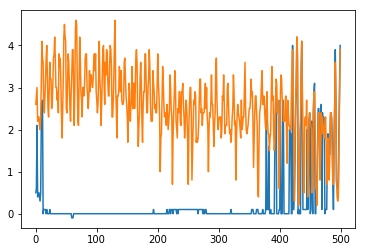

In [39]:
plt.plot(shift[:,0])
plt.plot(shift2[:,0])
plt.show()

You can clearly see the difference. Blue curve is RAW data, orange - filtered.

## Outline

Cross-correlation between two images is very sensitive to noise. That is why you should filter your RAW images before applying cross-correlation to them.

- Apply to the RAW image - gaussian filter with sigma = 3-5 pixels + Edge filter (Laplacian)
- ff-correction doesn't affect the result much, however RAW image may be slightly better in terms of more high-frequency details (dust particles), whowever having an additional low-frequency noise (monochromator stripes)

- bigger ROI helps to reduce the error of cross-correlation. I find 1/2 ROI to be optimal for quality-speed balance
- The error of finding shifts cross-correlation for my data is still around 0.5 pixel. 
- That is why one should use the accuracy = 10 (0.1 pixel) in skimage.feature.register_translation() module.